# Assignment 1.1: NARMA10 task with TDNN
This task consists of predicting the output of a 10th order non-linear autoregressive moving average (NARMA) system.
Given the input value x(t), the task is to predict the corresponding value of y(t).
* Import the dataset from the .csv file “NARMA10.csv” (available on the Moodle platform), where the first row represents the input, and the second row represents the target output. Different columns represent different time-steps.
* Split the data into training (the first 5000 time steps), and test set (remaining time steps). Note that for model selection you will use the data in the training set, with a further split in training (first 4000 samples) and validation (last 1000 samples).
* For the sake of problem understanding, you can try to first visualize the time-series data (using the matplotlib library in Python or the plot command in Matlab)

Remember: when training an RNN, you want to make sure to keep the last hidden state of your RNN after the training session, and use it as initial hidden state of the validation session. The same applies when transitioning to the test session.

1) Create and train a Time Delay Neural Network (TDNN) to solve the task, considering the fundamental hyperparameters (e.g., length of the input delay, training function/optimizer, learning rate, number of training epochs, etc.).

2) Perform a model selection (e.g., by grid search or random search) on the values of the hyperparameters identified in the previous point. Select on the validation set the best hyper-parametrization, as the one with the smallest Mean Squared Error (MSE).

3) Train the TDNN model with the selected hyper-parametrization on the whole training set, and evaluate its MSE on the training set and on the test set.

4) Repeat steps (1)-(3) also for Recurrent Neural Network (RNN), considering in this case the appropriate hyperparameters (e.g., in this case you don’t have an input delay line)

# Bonus-track Assignment 1.2: Mackey-Glass 17 task with TDNN

The data for this task is available in the file “MG17.csv” (available on the Moodle platform), and it consists of one single row containing the values of the Q(t) time-series for all the time-steps in the different columns. The task consists in predicting 1 step in the future the Mackey-Glass dynamical system, i.e. predicting the value Q(t+1), just looking at Q(t) (or at a tapped delay line of order s, i.e. Q(t),...,Q(t-s), for a TDNN). Before splitting the data into training, validation and test splits, you need to organize it into input and target information. Specifically, the input should consist of the time-series values from the first time-step to the second-to-last, and the target in the time-series value from the second time-step to the last.

## Libraries

In [1]:
import sys, copy, torch, json
import pandas as pd

from tqdm import tqdm
from numpy import ndarray, vstack
from typing import Tuple
from itertools import product

from torch import Tensor, no_grad, zeros
from torch.optim import Adam

# To work with Google colab
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Utils/utils.py
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/LAB3_1/Assignment1/models.py
#!mkdir caches

from Utils.utils import show_split, show_result, show_loss, make_sequence
from LAB3_1.Assignment1.models import TimeDelayNN

In [2]:
# To work with Google colab
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Sources/NARMA10.csv
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Sources/MG17.csv
source1 = pd.read_csv("./../../Sources/NARMA10.csv", header=None).T.to_numpy()
source2 = pd.read_csv("./../../Sources/MG17.csv", header=None).T.to_numpy()

## Retrieve the datasets

## Trainer and Grid-search function

In [3]:
class TDNN_trainer:
    def __init__(self,units:int, back_steps:int, dt_type:str):

        self.model = TimeDelayNN(units, back_steps) # model
        self.back_steps = back_steps
        self.dt_type = dt_type

    def fit(self, df:ndarray, epochs:int=2, lr:float=0.001)->Tensor:
        """
        Give the raw dataset dt, the number of epochs and the learning rate.
        It fits the model and returns the training loss history.
        """

        # Build sequences like [x1,x2,x3] -> [x4] , [x2,x3,x4] -> [x5] and so on
        x, y = make_sequence(df, self.back_steps + 1, self.dt_type)

        opt = Adam(self.model.parameters(), lr)
        history_tr = zeros(epochs) # Keep track the behavior of loss

        self.model.train()
        for i in range(epochs):

            opt.zero_grad(set_to_none=True)
            loss, _ = self.model(x, y) # perform the output
            loss.backward()
            opt.step()

            # save the current loss
            history_tr[i] = loss.item()

        return history_tr # return the history of loss

    def validate(self, df:ndarray) -> Tuple:
        """
        Given a validation dataset, it performs the loss
        """
        x, y = make_sequence(df, self.back_steps + 1, self.dt_type)
        return self.predict(x, y) + (y,)

    def predict(self, x:Tensor, y:Tensor=None):
        """
        Predict the output of a certain input, if the target it is provided, the method performs also the loss,
        otherwise return only the output of the network.
        """

        self.model.eval()
        with no_grad():
            return self.model(x, y)

In [4]:
class GridSearch:

    def __init__(self, parameters_grid:dict, tr:ndarray, dev:ndarray, dt_type:str):

        all_configs = [dict(zip(parameters_grid.keys(), configs)) for configs in product(*parameters_grid.values())]

        print("Number of configurations to try: ",len(all_configs))

        """
        Returns the performance in each configuration:

            rank = a list of results for each configuration
            best = best model used to final retrain
            loss = training loss history of the best model
        """
        rank, best, loss = self.run(tr, dev, all_configs, dt_type)

        # we sort by validation loss
        rank = sorted(rank, key=lambda conf: conf[2])

        print("\nThe best solution in ", rank[0])
        self.best_config = rank[0][0]
        self.best_model = best # the best model discovered
        self.tr_loss = loss # loss history

    @staticmethod
    def run(tr:ndarray, dev:ndarray, configs:list, dt_type:str):
        """
        In the grid search, we explore all configurations provided and try to find the best
        hyperparameter configuration using the training set to train the model and the validation
        set to compare the performance among all models instantiated by configurations.
        """

        rank = [] # keep in track the configuration and the corresponding performance

        # we save the best trained model and the training loss history during the epochs
        best, loss = None, None
        best_dev_loss = sys.maxsize

        for config in tqdm(configs): # try each configuration

            trainer = TDNN_trainer(units=config["units"],
                                   back_steps=config["b_step"],
                                   dt_type=dt_type)

            history = trainer.fit(tr, config["epochs"], config["lr"])
            vl_loss = trainer.validate(dev)[0].item()

            rank.append((config, round(history[-1].item(), 6), round(vl_loss, 6)))

            # we keep the best model
            if best_dev_loss > vl_loss:
                best_dev_loss = vl_loss
                loss = copy.deepcopy(history)
                best = copy.deepcopy(trainer)

        return rank, best, loss

## NARMA10

### Hold-out

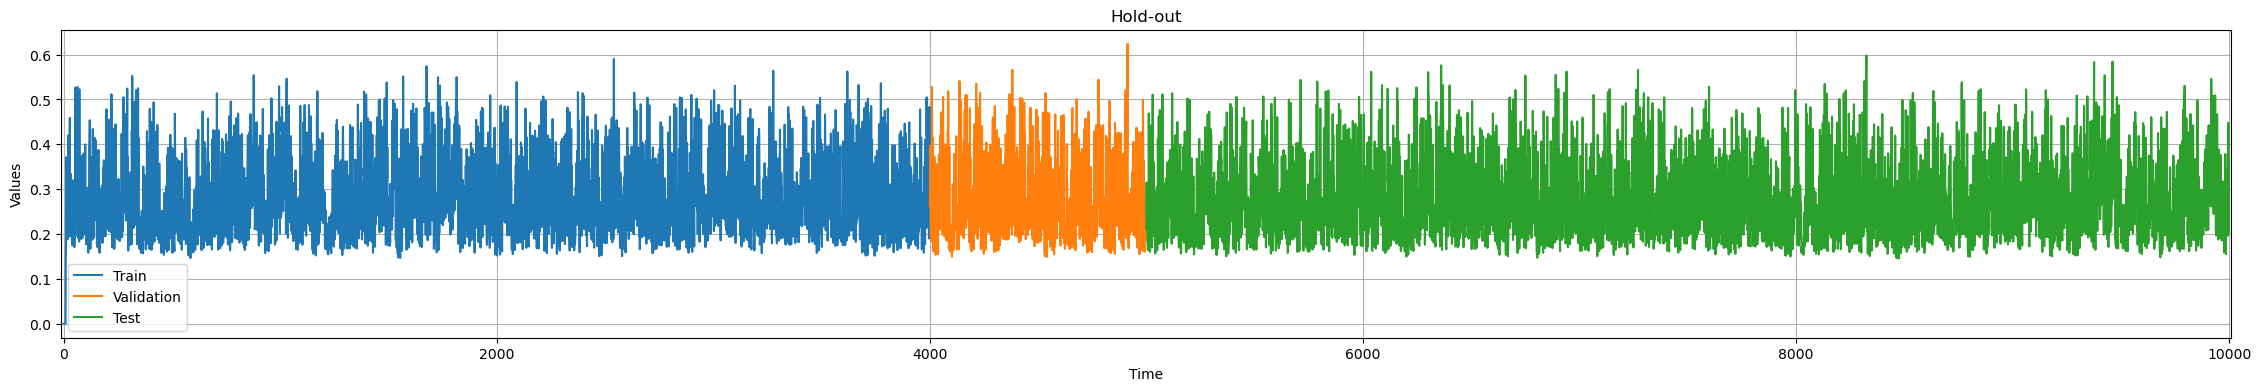

In [5]:
tr_dataset, dev_dataset, ts_dataset = source1[:4000], source1[4000:5000], source1[5000:]
# Although is not much representative, we plot the time target
show_split(tr_dataset, dev_dataset, ts_dataset)

### Grid search

In [6]:
json_dictionary = {"NARMA": {}, "MG17": {}}

In [7]:
ranges_to_explore = {
    "units" : [5, 10, 20, 50, 100, 500],
    "epochs" : [10, 20, 50, 100],
    "lr" : [0.0005, 0.001, 0.003, 0.005],
    "b_step" : [5, 8, 10, 12, 15, 20]
}

gs = GridSearch(ranges_to_explore, tr_dataset, dev_dataset, "NARMA10")
best_config = gs.best_config
best_model = gs.best_model

json_dictionary["NARMA"]["best_config"] = best_config

Number of configurations to try:  576


100%|██████████| 576/576 [03:17<00:00,  2.91it/s]


The best solution in  ({'units': 20, 'epochs': 100, 'lr': 0.005, 'b_step': 12}, 0.001049, 0.00107)


### Training loss

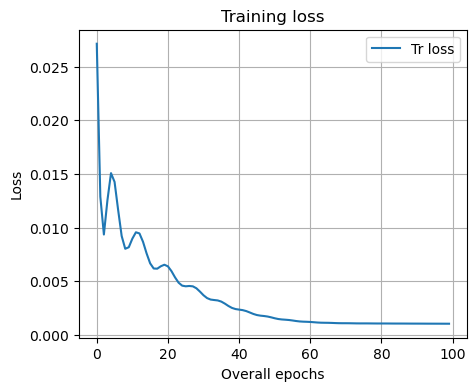

In [8]:
show_loss(gs.tr_loss)

### Train, Validation and Test errors in the best configuration

In [9]:
tr_loss = best_model.validate(tr_dataset)[0]
print("Train Error", round(tr_loss.item(), 6))

dev_loss = best_model.validate(dev_dataset)[0]
print("Validation Error", round(dev_loss.item(), 6))

ts_loss = best_model.validate(ts_dataset)[0]
print("Test Error", round(ts_loss.item(), 6))

json_dictionary["NARMA"]["best_config"] = best_config
json_dictionary["NARMA"]["Model_evaluation"] = (
    round(tr_loss.item(),6),
    round(dev_loss.item(),6),
    round(ts_loss.item(),6))

Train Error 0.001048
Validation Error 0.00107
Test Error 0.00108


### Final retrain with Training and Validation set (with the best configuration)

In [10]:
final_trainer = TDNN_trainer(units=best_config["units"],
                             back_steps=best_config["b_step"],
                             dt_type="NARMA10")

# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
final_tr = vstack([tr_dataset, dev_dataset])
tr_history = final_trainer.fit(final_tr, best_config["epochs"], lr=best_config["lr"])

tr_loss, tr_pred, tr_y = final_trainer.validate(final_tr)
print("Training Error", round(tr_loss.item(), 6))

ts_loss, ts_pred, test_y = final_trainer.validate(ts_dataset)
print("Test Error", round(ts_loss.item(), 6))

json_dictionary["NARMA"]["Final_retrain"] = (
    round(tr_loss.item(),6),
    round(ts_loss.item(),6))

Training Error 0.00287
Test Error 0.002767


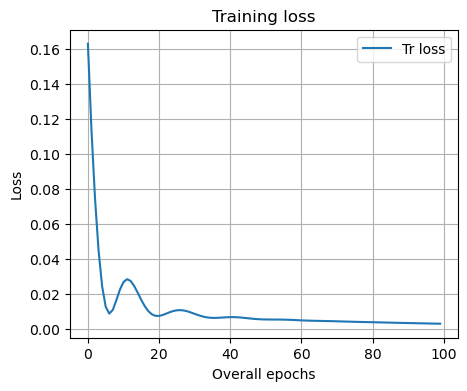

In [11]:
show_loss(tr_history)

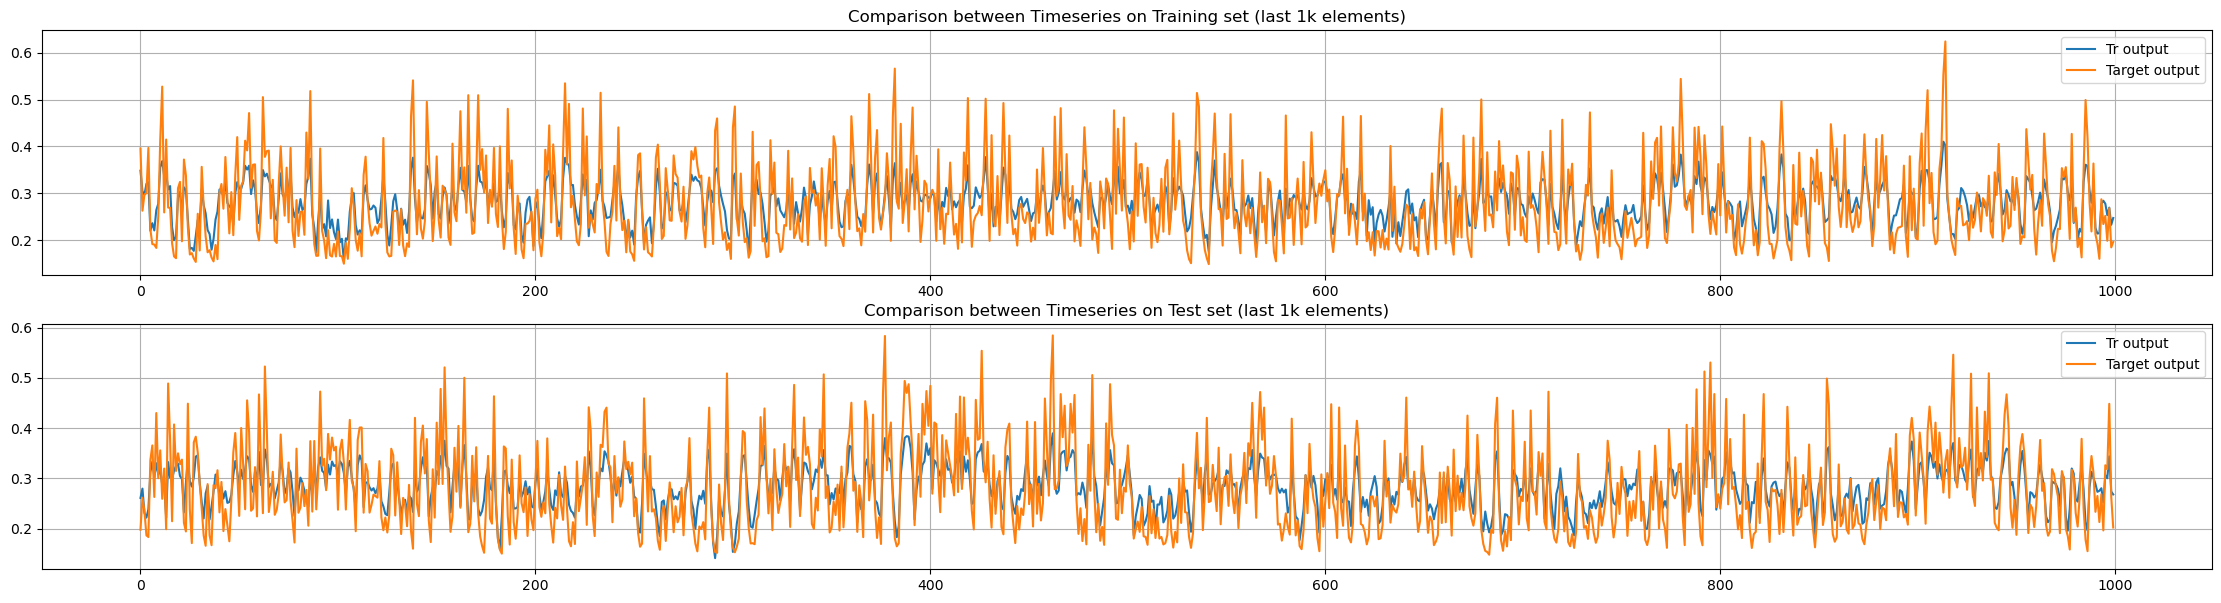

In [12]:
show_result(tr_pred, tr_y, ts_pred, test_y)

In [13]:
torch.save([best_model.model, gs.tr_loss, tr_pred, tr_y, ts_pred, test_y],"caches/narma_tdnn.pt")

## Mackey-Glass 17

### Hold out

In [14]:
tr_dataset, dev_dataset, ts_dataset = source2[:4000], source2[4000:5000], source2[5000:]

### Grid search

In [15]:
ranges_to_explore = {
    "units" : [5, 10, 20, 50, 100, 500],
    "epochs" : [10, 20, 50, 100],
    "lr" : [0.0005, 0.001, 0.003, 0.005],
    "b_step" : [5, 8, 10, 12, 15, 20]
}

gs = GridSearch(ranges_to_explore, tr_dataset, dev_dataset, "MG17")
best_config = gs.best_config
best_model = gs.best_model

Number of configurations to try:  576


100%|██████████| 576/576 [03:13<00:00,  2.97it/s]


The best solution in  ({'units': 500, 'epochs': 100, 'lr': 0.003, 'b_step': 12}, 0.000131, 0.000123)


### Training loss

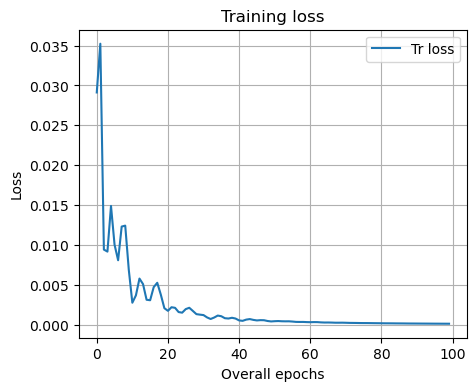

In [16]:
show_loss(gs.tr_loss)

### Train, Validation and Test errors in the best configuration

In [17]:
tr_loss = best_model.validate(tr_dataset)[0]
print("Train Error", round(tr_loss.item(), 6))

dev_loss = best_model.validate(dev_dataset)[0]
print("Validation Error", round(dev_loss.item(), 6))

ts_loss = best_model.validate(ts_dataset)[0]
print("Test Error", round(ts_loss.item(), 6))

json_dictionary["MG17"]["best_config"] = best_config
json_dictionary["MG17"]["Model_evaluation"] = (
    round(tr_loss.item(),6),
    round(dev_loss.item(),6),
    round(ts_loss.item(),6))

Train Error 0.000129
Validation Error 0.000123
Test Error 0.000126


### Final retrain with Training and Validation set (with the best configuration)

In [18]:
final_trainer = TDNN_trainer(units=best_config["units"],
                             back_steps=best_config["b_step"],
                             dt_type="MG17")

# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
final_tr = vstack([tr_dataset, dev_dataset])
tr_history = final_trainer.fit(final_tr, best_config["epochs"], lr=best_config["lr"])

tr_loss, tr_pred, tr_y = final_trainer.validate(final_tr)
print("Training Error", round(tr_loss.item(), 6))

ts_loss, ts_pred, test_y = final_trainer.validate(ts_dataset)
print("Test Error", round(ts_loss.item(), 6))

json_dictionary["MG17"]["Final_retrain"] = (
    round(tr_loss.item(),6),
    round(ts_loss.item(),6))

Training Error 0.000311
Test Error 0.000311


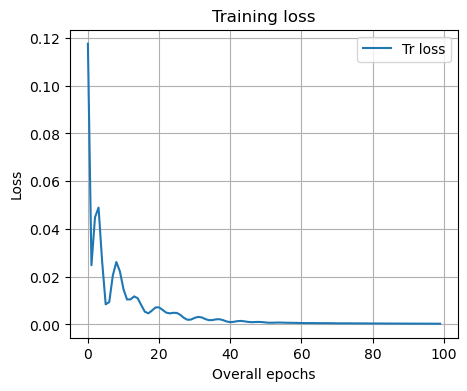

In [19]:
show_loss(tr_history)

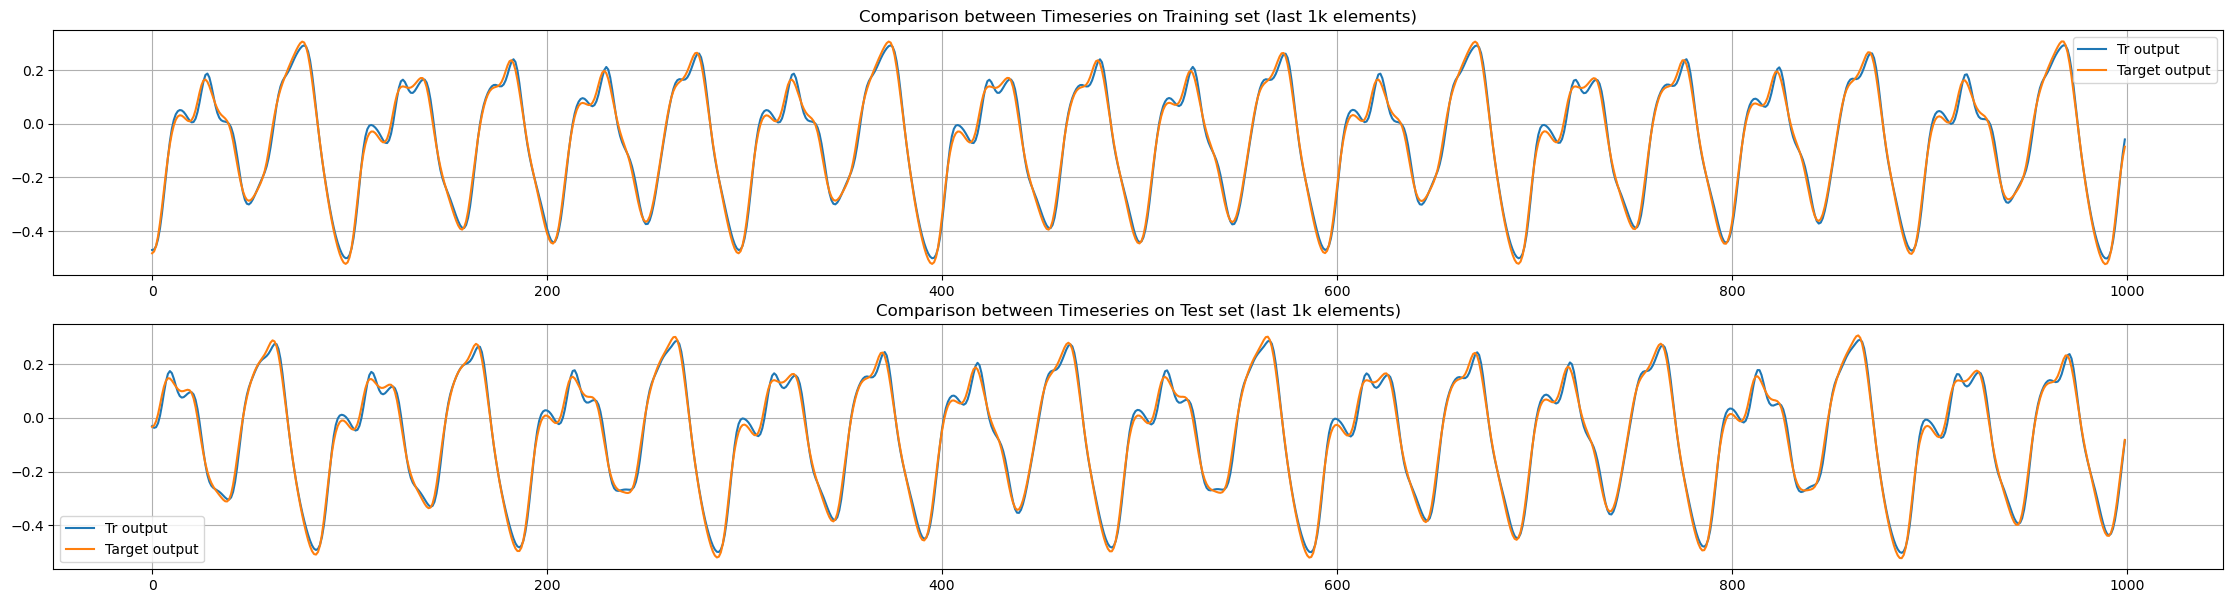

In [20]:
show_result(tr_pred, tr_y, ts_pred, test_y)

In [21]:
torch.save([best_model.model,gs.tr_loss, tr_pred, tr_y, ts_pred, test_y],"caches/mg17_tdnn.pt")

In [22]:
with open("caches/metric_tdnn.json", "w") as outfile:
    outfile.write(json.dumps(json_dictionary))